In [113]:
import pandas as pd
import numpy as np

from shapely.geometry import Point, shape, mapping
from shapely.ops import unary_union

import matplotlib.pyplot as plt
import seaborn as sns

#from geoband.API import *
import folium
import json
import geopandas as gpd
from geopandas import gpd

from folium import plugins
import re
from pandas import ExcelFile

- 공간자기상관성(Spatial Autocorrelation) 검정
- 머신러닝 모형
    - XGBoost, LightGBM, Random Forest
- 공간모형
    - 공간회귀모형, 지리가중회귀분석

In [114]:
data = pd.read_csv("data/finaldata0617.csv",encoding="cp949")

In [115]:
data.columns

Index(['serial', 'lat', 'lon', '초미세먼지(㎍/㎥)', '미세먼지(㎍/㎥)', '기온(℃)', '상대습도( %)',
       '초미세먼지 보정(㎍/㎥)', '미세먼지 보정(㎍/㎥)', 'geometry_x', '버스승차승객수', '버스하차승객수',
       '대여', '반납', 'traffic', 'road', 'subway', 'vent', 'parking', '구동',
       'geometry_y', '통계청행정동코드', '행자부행정동코드', '시군구명', '행정동명', '경도', '위도',
       '총생활인구수', '남10대생활인구수', '여10대생활인구수', '남20대생활인구수', '여20대생활인구수',
       '남30,40대생활인구수', '여30,40대생활인구수', '남50,60대생활인구수', '여50,60대생활인구수',
       '남자70세이상생활인구수', '여자70세이상생활인구수', '자치구', '동', '세대', '인구', '세대당인구',
       '외국인인구비율', '구내전입', '구내전출', '구간전입', '구간전출', '인구밀도', 'park', 'tree',
       'river'],
      dtype='object')

In [116]:
data.shape

(1060, 52)

In [117]:
data.isnull().sum()

serial            0
lat               0
lon               0
초미세먼지(㎍/㎥)        0
미세먼지(㎍/㎥)         0
기온(℃)             0
상대습도( %)          0
초미세먼지 보정(㎍/㎥)     0
미세먼지 보정(㎍/㎥)      0
geometry_x        0
버스승차승객수           0
버스하차승객수           0
대여                0
반납                0
traffic           0
road              0
subway            0
vent              0
parking           0
구동                4
geometry_y        4
통계청행정동코드          9
행자부행정동코드          9
시군구명              9
행정동명              9
경도                4
위도                4
총생활인구수            4
남10대생활인구수         4
여10대생활인구수         4
남20대생활인구수         4
여20대생활인구수         4
남30,40대생활인구수      4
여30,40대생활인구수      4
남50,60대생활인구수      4
여50,60대생활인구수      4
남자70세이상생활인구수      4
여자70세이상생활인구수      4
자치구              12
동                12
세대                4
인구                4
세대당인구             4
외국인인구비율           4
구내전입              4
구내전출              4
구간전입              4
구간전출              4
인구밀도              4
park              0


In [118]:
data.loc[data.인구.isnull(),:]

,serial,lat,lon,초미세먼지(㎍/㎥),미세먼지(㎍/㎥),기온(℃),상대습도( %),초미세먼지 보정(㎍/㎥),미세먼지 보정(㎍/㎥),geometry_x,...,세대당인구,외국인인구비율,구내전입,구내전출,구간전입,구간전출,인구밀도,park,tree,river
988,OC3CL200061,37.424820,127.019676,23.233577,61.503650,12.363139,52.412409,22.726277,78.200730,POINT (127.0196764 37.4248203),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
989,OC3CL200010,37.428772,127.016074,24.127090,62.267559,13.032776,48.869565,25.458194,76.013378,POINT (127.0160739 37.42877164),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
990,OC3CL200065,37.434363,127.011336,19.089965,47.892734,12.772318,48.705882,20.093426,65.408304,POINT (127.0113356 37.43436316),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
991,OC3CL200011,37.422013,127.024266,18.304636,39.546358,21.600000,88.000000,19.794702,56.874172,POINT (127.0242658 37.42201307),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0


과천 쪽 서울대공원 부근이어서 네 개 제외 

In [119]:
data = data.loc[:,['미세먼지(㎍/㎥)','lat', 'lon','기온(℃)', '상대습도( %)','버스승차승객수', '버스하차승객수','대여', '반납', 'traffic', 'road', 'subway', 'vent', 'parking','남10대생활인구수', '여10대생활인구수', '남20대생활인구수', '여20대생활인구수',
       '남30,40대생활인구수', '여30,40대생활인구수', '남50,60대생활인구수', '여50,60대생활인구수',
       '남자70세이상생활인구수', '여자70세이상생활인구수', '세대', '인구', '세대당인구',
       '외국인인구비율', '구내전입', '구내전출', '구간전입', '구간전출', '인구밀도', 'park', 'tree',
       'river']]

In [120]:
data.columns

Index(['미세먼지(㎍/㎥)', 'lat', 'lon', '기온(℃)', '상대습도( %)', '버스승차승객수', '버스하차승객수',
       '대여', '반납', 'traffic', 'road', 'subway', 'vent', 'parking', '남10대생활인구수',
       '여10대생활인구수', '남20대생활인구수', '여20대생활인구수', '남30,40대생활인구수', '여30,40대생활인구수',
       '남50,60대생활인구수', '여50,60대생활인구수', '남자70세이상생활인구수', '여자70세이상생활인구수', '세대',
       '인구', '세대당인구', '외국인인구비율', '구내전입', '구내전출', '구간전입', '구간전출', '인구밀도',
       'park', 'tree', 'river'],
      dtype='object')

- 사용할 종속변수 : `미세먼지` 
- 독립변수 31개: `버스승차승객수`, `버스하차승객수`, `대여`, `반납`, `traffic`, `road`,`subway`, `vent`, `parking`, `남10대생활인구수`, `여10대생활인구수`, `남20대생활인구수`,`여20대생활인구수`, `남30,40대생활인구수`, `여30,40대생활인구수`, `남50,60대생활인구수`,`여50,60대생활인구수`, `남자70세이상생활인구수`, `여자70세이상생활인구수`, `세대`, `인구`, `세대당인구`, `외국인인구비율`, `구내전입`, `구내전출`, `구간전입`, `구간전출`, `인구밀도`, `park`, `tree`,`river`

In [121]:
data = data.rename(columns={'미세먼지(㎍/㎥)':"finedust","기온(℃)":"temp","상대습도( %)":"humid","버스승차승객수": "busin", "버스하차승객수": "busout","대여":"bikerent","반납":"bikereturn",'남10대생활인구수':"m10", '여10대생활인구수':"f10", '남20대생활인구수':"m20", '여20대생활인구수':"f20",'남30,40대생활인구수':"m3040", '여30,40대생활인구수':"f3040", '남50,60대생활인구수':"m5060", '여50,60대생활인구수':"f5060",
       '남자70세이상생활인구수':"m70", '여자70세이상생활인구수':"f70", '세대':"fam", '인구':"pop", '세대당인구':"famperpop",
       '외국인인구비율':"foreign_rt", '구내전입':"gu_in", '구내전출':"gu_out", '구간전입':"gugan_in", '구간전출':"gugan_out", '인구밀도':"pop_dens"})

### 데이터 check

In [122]:
data.dtypes

finedust      float64
lat           float64
lon           float64
temp          float64
humid         float64
busin         float64
busout        float64
bikerent      float64
bikereturn    float64
traffic       float64
road            int64
subway          int64
vent            int64
parking         int64
m10           float64
f10           float64
m20           float64
f20           float64
m3040         float64
f3040         float64
m5060         float64
f5060         float64
m70           float64
f70           float64
fam           float64
pop           float64
famperpop     float64
foreign_rt    float64
gu_in         float64
gu_out        float64
gugan_in      float64
gugan_out     float64
pop_dens      float64
park            int64
tree            int64
river           int64
dtype: object

In [123]:
data = data.dropna()

### NA 체크

In [124]:
data.isnull().sum()

finedust      0
lat           0
lon           0
temp          0
humid         0
busin         0
busout        0
bikerent      0
bikereturn    0
traffic       0
road          0
subway        0
vent          0
parking       0
m10           0
f10           0
m20           0
f20           0
m3040         0
f3040         0
m5060         0
f5060         0
m70           0
f70           0
fam           0
pop           0
famperpop     0
foreign_rt    0
gu_in         0
gu_out        0
gugan_in      0
gugan_out     0
pop_dens      0
park          0
tree          0
river         0
dtype: int64

### correlation check

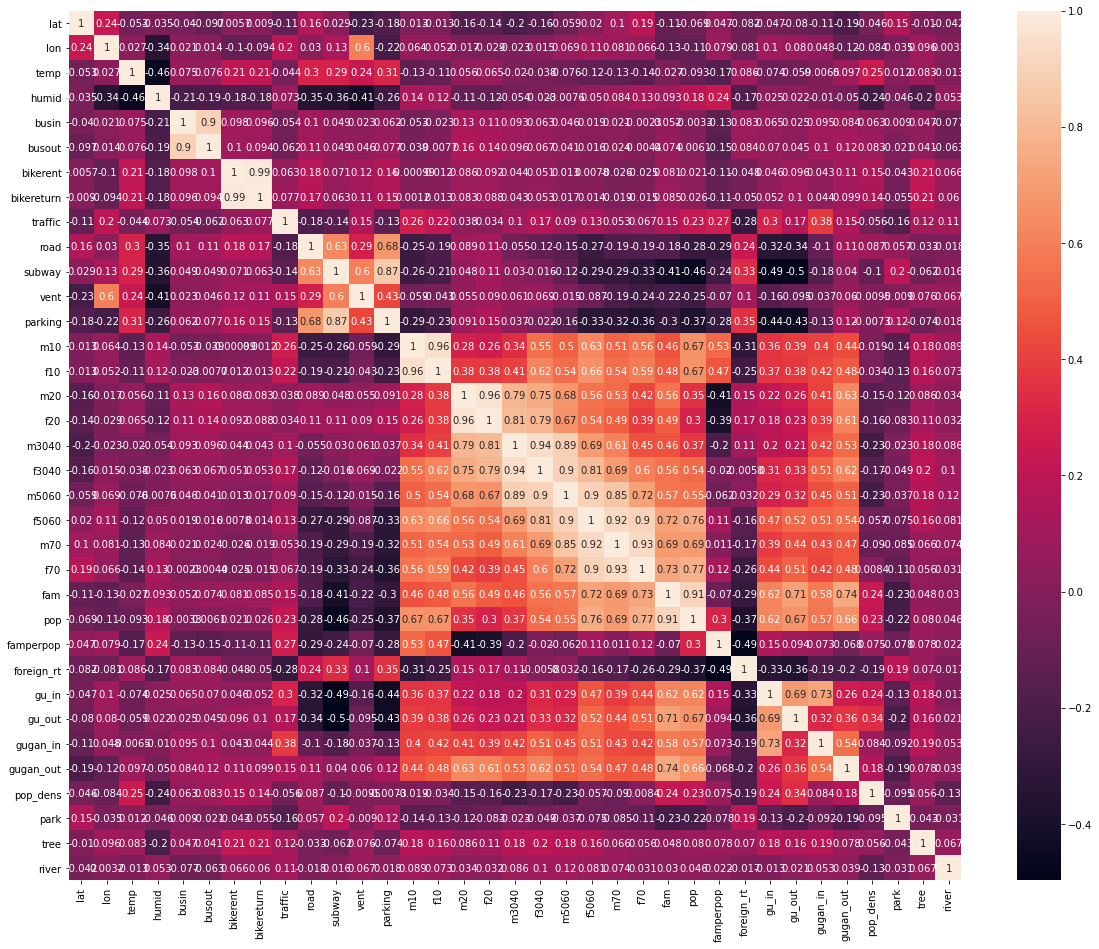

In [125]:
plt.figure(figsize=(20,16))
sns.heatmap(data.iloc[:,1:].corr(),annot=True)
plt.show()

In [126]:
for c1 in data.columns:
    for c2 in data.columns:
        if (data.corr().loc[c1,c2] >=0.7) & (data.corr().loc[c1,c2] <1.0):
            print(c1,"+",c2,":",data.corr().loc[c1,c2])

busin + busout : 0.8971336251119265
busout + busin : 0.8971336251119265
bikerent + bikereturn : 0.9905110971234323
bikereturn + bikerent : 0.9905110971234323
subway + parking : 0.8658408040510718
parking + subway : 0.8658408040510718
m10 + f10 : 0.9552772617633545
f10 + m10 : 0.9552772617633545
m20 + f20 : 0.9642623362453485
m20 + m3040 : 0.7896732970469449
m20 + f3040 : 0.7500157900539358
f20 + m20 : 0.9642623362453485
f20 + m3040 : 0.8106657606751442
f20 + f3040 : 0.7924029527079118
m3040 + m20 : 0.7896732970469449
m3040 + f20 : 0.8106657606751442
m3040 + f3040 : 0.9442653356139069
m3040 + m5060 : 0.8873106948770814
f3040 + m20 : 0.7500157900539358
f3040 + f20 : 0.7924029527079118
f3040 + m3040 : 0.9442653356139069
f3040 + m5060 : 0.8976006108982111
f3040 + f5060 : 0.8135028846272041
m5060 + m3040 : 0.8873106948770814
m5060 + f3040 : 0.8976006108982111
m5060 + f5060 : 0.8979985302104195
m5060 + m70 : 0.8489466276406924
m5060 + f70 : 0.7161336064514496
f5060 + f3040 : 0.81350288462720

In [127]:
data["bus"] = (data["busin"]+data["busout"])/2
data["bike"] = (data["bikerent"]+data["bikereturn"])/2
data["trans"] = (data["subway"]+data["parking"])
data["p10"] = data["m10"]+ data["f10"]
data["p20"] = data["m20"]+ data["f20"]
data["p3040"] = data["m3040"]+ data["f3040"]
data["p5060"] = data["m5060"]+ data["f5060"]
data["p70"] = data["m70"]+ data["f70"]

In [128]:
data.columns

Index(['finedust', 'lat', 'lon', 'temp', 'humid', 'busin', 'busout',
       'bikerent', 'bikereturn', 'traffic', 'road', 'subway', 'vent',
       'parking', 'm10', 'f10', 'm20', 'f20', 'm3040', 'f3040', 'm5060',
       'f5060', 'm70', 'f70', 'fam', 'pop', 'famperpop', 'foreign_rt', 'gu_in',
       'gu_out', 'gugan_in', 'gugan_out', 'pop_dens', 'park', 'tree', 'river',
       'bus', 'bike', 'trans', 'p10', 'p20', 'p3040', 'p5060', 'p70'],
      dtype='object')

In [129]:
data = data.drop(columns = ['busin', 'busout', 'bikerent', 'bikereturn',"subway","parking",'m10', 'f10', 'm20', 'f20',
       'm3040', 'f3040', 'm5060', 'f5060', 'm70', 'f70'])

In [130]:
for c1 in data.columns:
    for c2 in data.columns:
        if (data.corr().loc[c1,c2] >=0.7) & (data.corr().loc[c1,c2] <1.0):
            print(c1,"+",c2,":",data.corr().loc[c1,c2])

fam + pop : 0.9108675173614469
fam + gu_out : 0.7078132824348348
fam + gugan_out : 0.7425485093556661
fam + p70 : 0.7275746392166471
pop + fam : 0.9108675173614469
pop + p70 : 0.752720300168631
gu_in + gugan_in : 0.7272527192730184
gu_out + fam : 0.7078132824348348
gugan_in + gu_in : 0.7272527192730184
gugan_out + fam : 0.7425485093556661
p20 + p3040 : 0.8076831081393427
p3040 + p20 : 0.8076831081393427
p3040 + p5060 : 0.8525157420233715
p5060 + p3040 : 0.8525157420233715
p5060 + p70 : 0.8758053875177755
p70 + fam : 0.7275746392166471
p70 + pop : 0.752720300168631
p70 + p5060 : 0.8758053875177755


In [131]:
data["p20_60"] = data["p20"]+ data["p3040"]+ data["p5060"]

In [132]:
data =data.drop(columns = ["p20","p3040","p5060","fam","gugan_in"])

In [133]:
for c1 in data.columns:
    for c2 in data.columns:
        if (data.corr().loc[c1,c2] >=0.7) & (data.corr().loc[c1,c2] <1.0):
            print(c1,"+",c2,":",data.corr().loc[c1,c2])

pop + p70 : 0.752720300168631
p70 + pop : 0.752720300168631


data

### 종속변수 체크 

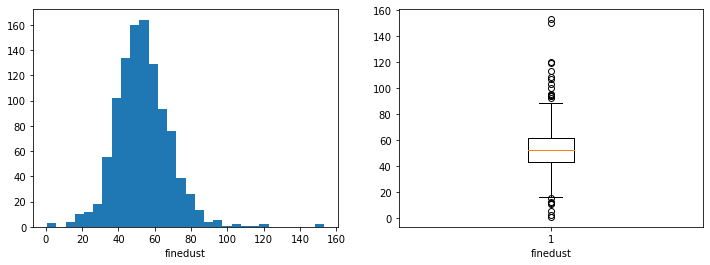

In [134]:
fig = plt.figure(figsize=(12,4))
ax1= fig.add_subplot(1, 2, 1)
ax1 = plt.hist(data.finedust,bins=30)
ax1 = plt.xlabel("finedust")
ax2= fig.add_subplot(1, 2, 2)
ax2 = plt.boxplot(data.finedust)
ax2 = plt.xlabel("finedust")

### 독립변수 체크

<ipython-input-135-7406f692ceeb>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12,4))


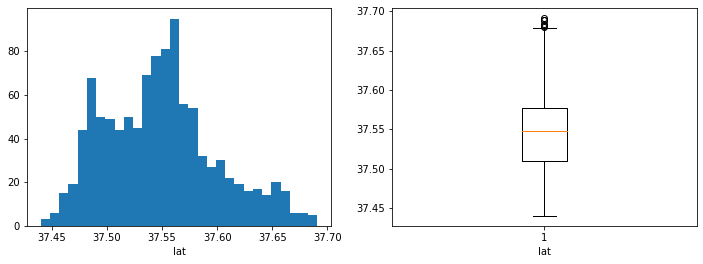

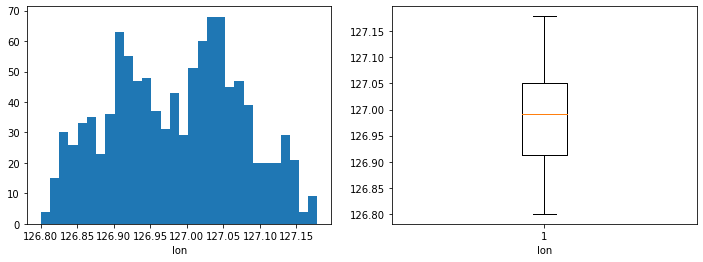

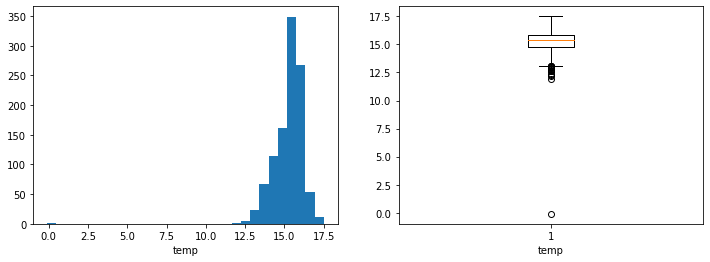

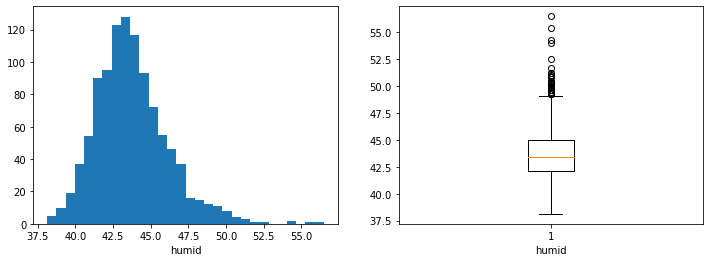

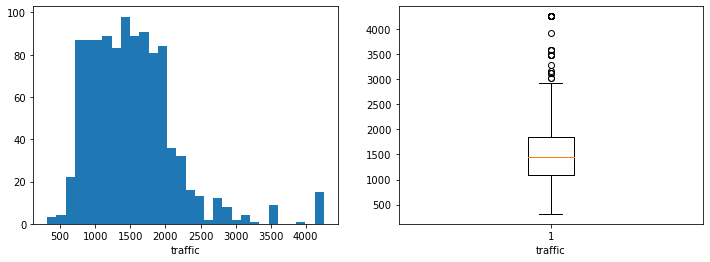

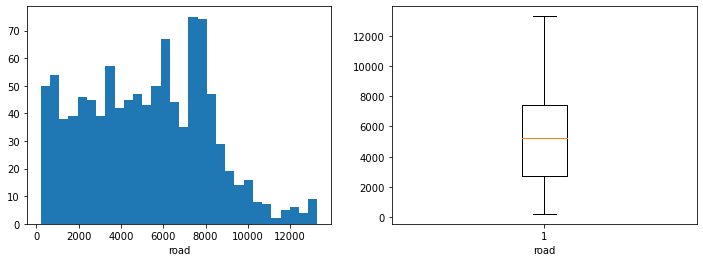

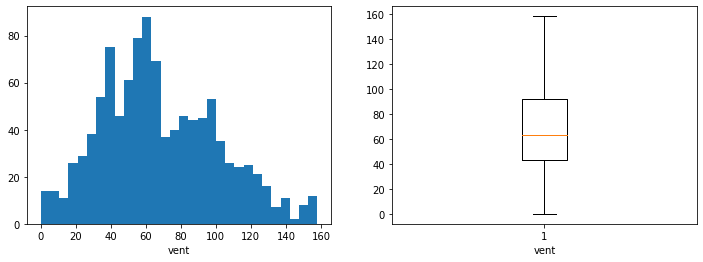

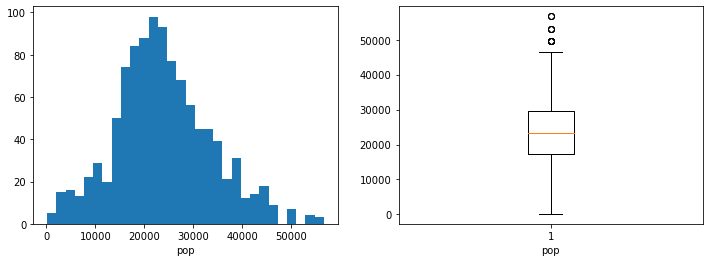

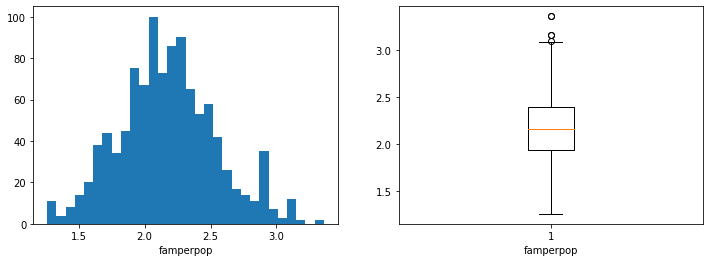

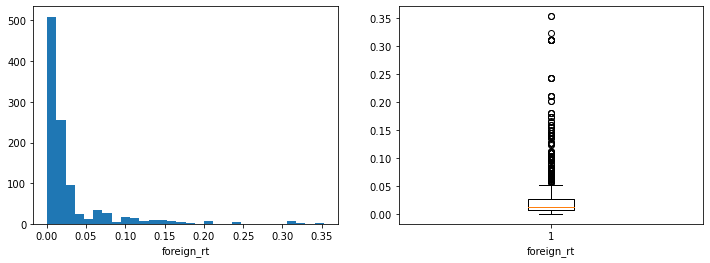

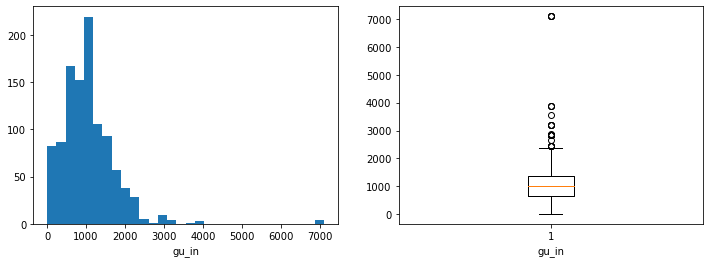

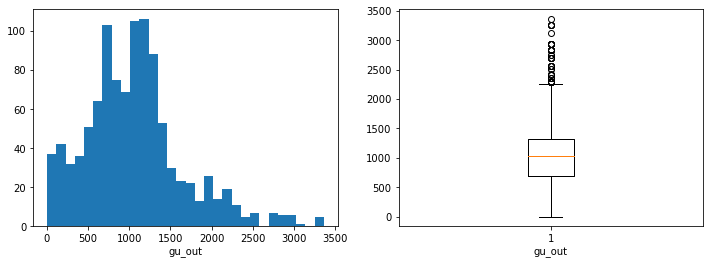

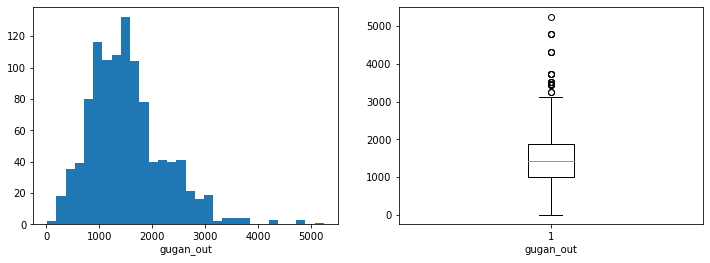

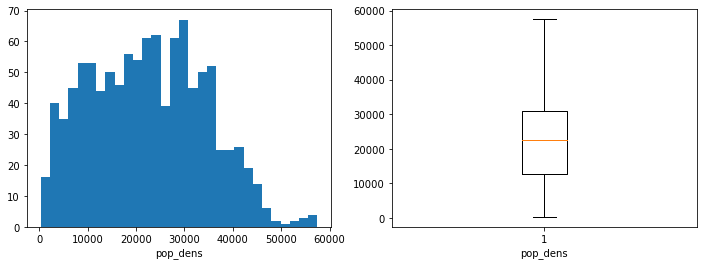

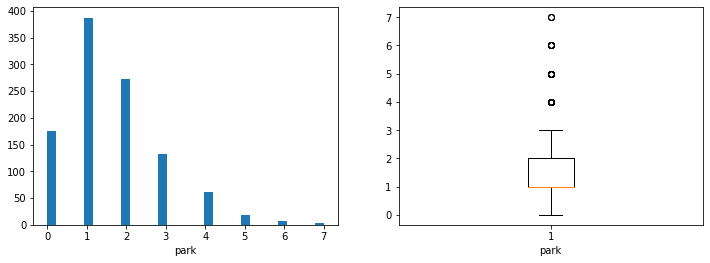

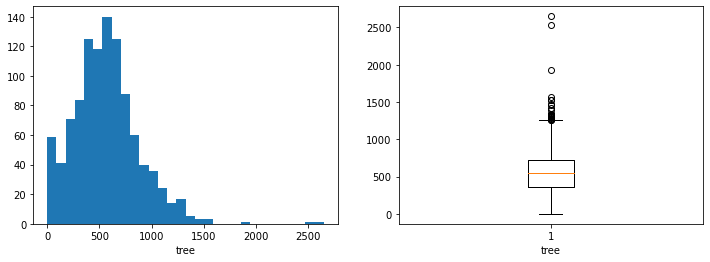

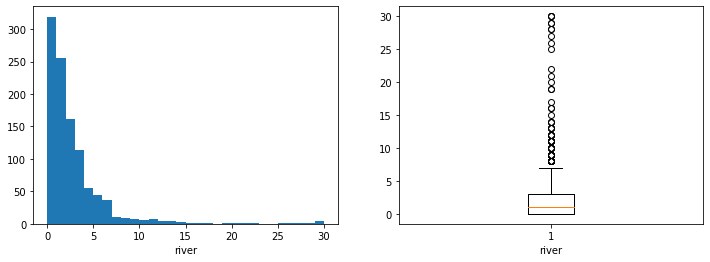

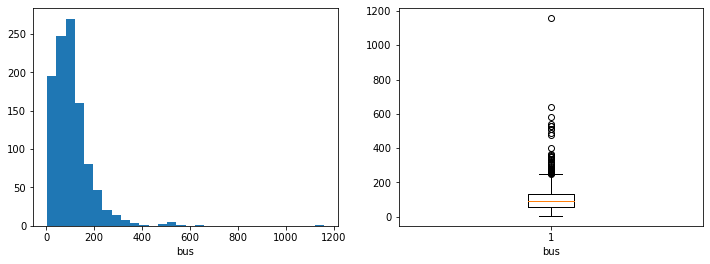

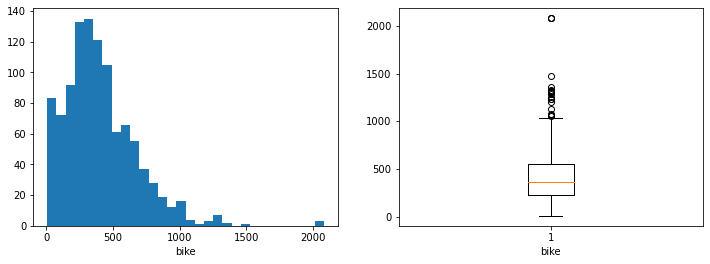

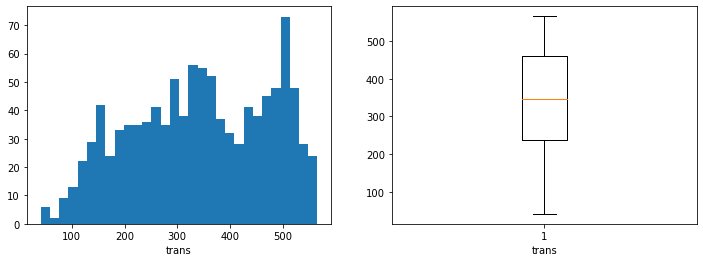

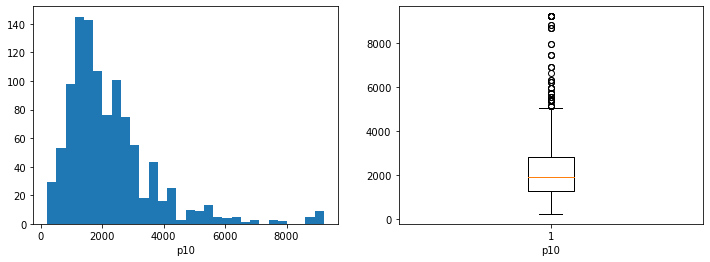

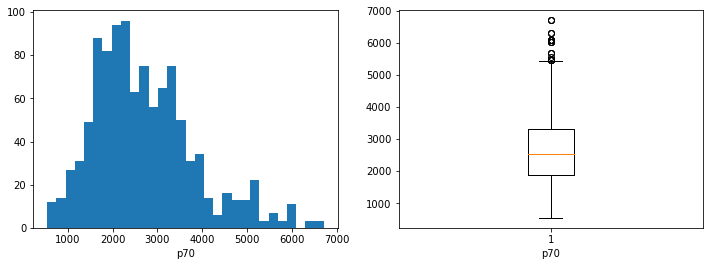

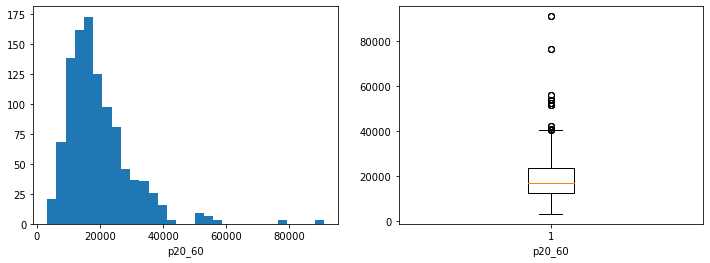

In [135]:
for c in data.columns[1:]:
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(1, 2, 1)
    ax = plt.hist(data[c],bins=30)
    ax = plt.xlabel(c)
    
    ax1 = fig.add_subplot(1, 2, 2)
    ax1 = plt.boxplot(data[c])
    ax1 = plt.xlabel(c)

### 변수 업데이트
- 사용할 종속변수 : `미세먼지` 
- 독립변수 19개: 'traffic', 'road', 'vent', 'pop', 'famperpop', 'foreign_rt',
       'gu_in', 'gu_out', 'gugan_out', 'pop_dens', 'park', 'tree', 'river',
       'bus', 'bike', 'trans', 'p10', 'p70', 'p20_60'
- 데이터 개수 1056개

In [136]:
data.columns

Index(['finedust', 'lat', 'lon', 'temp', 'humid', 'traffic', 'road', 'vent',
       'pop', 'famperpop', 'foreign_rt', 'gu_in', 'gu_out', 'gugan_out',
       'pop_dens', 'park', 'tree', 'river', 'bus', 'bike', 'trans', 'p10',
       'p70', 'p20_60'],
      dtype='object')

In [137]:
data.shape

(1056, 24)

In [138]:
y = data["finedust"]
X = data.iloc[:,1:] 

In [139]:
y.shape

(1056,)

In [140]:
X.shape

(1056, 23)

data.to_csv("data/finaldata_0618.csv",encoding = "cp949",index = False)

### Scaling

In [141]:
from sklearn.model_selection import train_test_split
X_tr, X_tst, y_tr, y_tst = train_test_split(X,y,test_size = 0.2,random_state = 42)
print(X_tr.shape,y_tr.shape,X_tst.shape,y_tst.shape)

(844, 23) (844,) (212, 23) (212,)


In [145]:
X_tr = X_tr.reset_index(drop=True)
X_tst = X_tst.reset_index(drop=True)

In [152]:
m = folium.Map(
    location=[37.54238169591348,126.99068745821812],
 attr = '서울',
    zoom_start=12
)

for i in range(len(X_tr)):
    folium.Circle(
    location = [X_tr.lat[i],X_tr.lon[i]],
    radius = 100,
    color = "black").add_to(m)
for i in range(len(X_tst)):
    folium.Circle(
    location = [X_tst.lat[i],X_tst.lon[i]],
    radius = 100,
    color = "red").add_to(m)
folium.plugins.Fullscreen(position='topright',  
                   title='FULL SCREEN ON', 
                   title_cancel='FULL SCREEN OFF',
                   force_separate_button=True
                  ).add_to(m)
m

In [98]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_tr)

X_tr = scaler.transform(X_tr)
X_tst = scaler.transform(X_tst)

### Random Forest

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [100]:
param_grid = {'bootstrap': [True],
 'max_depth': [ 30, 60,  90, None],
 'max_features': ['auto'],
 'min_samples_leaf': [4,8],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200,  600, 1000, 1600,  2000]}

In [101]:
rf = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, n_iter = 100, cv = 10, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_tr, y_tr)
rf_random.best_params_

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 19.8min finished


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 8,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': True}

In [102]:
bp = rf_random.best_params_

In [103]:
rf = RandomForestRegressor(random_state = 42,n_estimators = bp['n_estimators'],min_samples_split = bp["min_samples_split"],min_samples_leaf = 2,max_features = bp["max_features"],max_depth = bp["max_depth"],bootstrap = bp["bootstrap"])
rf = rf.fit(X_tr,y_tr)
y_tst_pred = rf.predict(X_tst)

In [104]:
y_tr_pred = rf.predict(X_tr)
y_tst_pred = rf.predict(X_tst)

In [105]:
mean_squared_error(y_tr,y_tr_pred)

48.7464323787943

In [106]:
r2_score(y_tr,y_tr_pred)

0.7954390612870832

In [107]:
mean_squared_error(y_tst,y_tst_pred)

187.57786074991373

In [108]:
r2_score(y_tst,y_tst_pred)

0.02446614127190727

In [109]:
y_tst1 = y_tst.reset_index(drop=True)

In [110]:
pd.concat([y_tst1,pd.DataFrame({"p":y_tst_pred})],axis=1)

,finedust,p
0,51.217391,54.603437
1,78.835664,50.102809
2,37.194719,51.648940
3,58.404762,65.651132
4,53.244300,54.215163
...,...,...
207,52.650155,48.653395
208,64.758865,68.629086
209,54.105442,49.702127
210,34.346505,49.470780


/Users/seungji/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='finedust'>

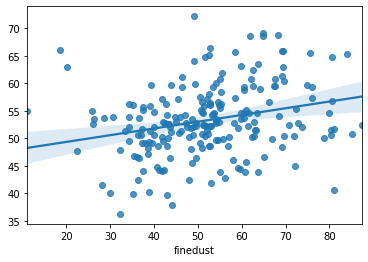

In [111]:
sns.regplot(y_tst1,y_tst_pred)

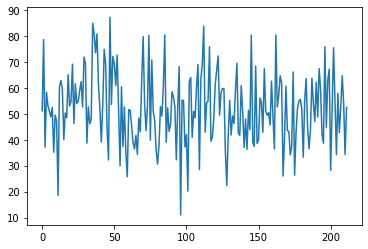

In [112]:
plt.plot(y_tst1)

In [68]:
sns.barplot(y = X_tr.columns[np.argsort(rf.feature_importances_)], x = list(rf.feature_importances_[np.argsort(rf.feature_importances_)]))
plt.show()      

AttributeError: 'numpy.ndarray' object has no attribute 'columns'